In [1]:
################################################################################
#####################  Xgboost HPO GPU for 2010 - 2020 #########################
############# Train 2020 Test 2010-19 & Train 2010-19 Test 2020 ################
################################################################################

In [2]:
!pip install category_encoders
!pip install xgboost==1.5.2
!pip install eli5
!pip install shap
import os
import random
import numpy as np
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold
import joblib
from hyperopt import STATUS_OK
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from hyperopt import hp
from hyperopt import tpe
from hyperopt import fmin, tpe, Trials
import csv
from datetime import datetime, timedelta
from timeit import default_timer as timer
import ast
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import eli5 as eli
from eli5.sklearn import PermutationImportance 
from eli5 import show_weights
import webbrowser
from eli5.sklearn import explain_weights_sklearn
from eli5.formatters import format_as_dataframe, format_as_dataframes
from eli5 import show_prediction
import shap

     |████████████████████████████████| 86 kB 2.9 MB/s 
     |████████████████████████████████| 173.6 MB 8.1 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
     |████████████████████████████████| 106 kB 5.3 MB/s 
     |████████████████████████████████| 564 kB 4.3 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [5]:
# Set seed 
seed_value = 42
os.environ['XgboostGPU_train20test1819'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [6]:
# Read data
df = pd.read_csv('combined_trade_final_LSTM.csv', low_memory=False)
df = df.drop_duplicates()
print('Number of rows and columns:', df.shape)

Number of rows and columns: (6703389, 22)


In [7]:
# Drop time and COVID-19 vars
df = df.drop(['State', 'DateTime', 'Date_Weekly_COVID', 'DateTime_YearWeek'],
             axis=1)

In [8]:
# Convert dtypes
df = df.copy()
df['State_Closure_EA_Diff'] = df['State_Closure_EA_Diff'].astype('float64')
df['Container_Type_Dry'] = df['Container_Type_Dry'].astype('object')

In [9]:
# Filter missing data
df = df[df.Foreign_Country_Region.notna() & df.Average_Tariff.notna()]

In [10]:
# Filter df to 2020
df = df[df['Year'] == 2020]

# Drop year variable
df = df.drop(['Year'], axis=1)

In [11]:
# Prepare 2020 for partitioning data
X = df.drop(['Metric_Tons'], axis=1)
y = df['Metric_Tons']

del df

In [12]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = seed_value)

In [13]:
# Training set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_train = ce_ord.fit_transform(X_train)

# Testing set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_test = ce_ord.fit_transform(X_test)

In [14]:
# Train: Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)

# Test: Create dummy variables for categorical variables
X_test = pd.get_dummies(X_test, drop_first=True)

In [15]:
# MinMax Scaling
mn = MinMaxScaler()
X_train = pd.DataFrame(mn.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(mn.fit_transform(X_test), columns = X_test.columns)

In [16]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Results/Xgboost/Results/

/content/drive/MyDrive/MaritimeTrade/Results/Xgboost/Results


In [17]:
# Access results
results = pd.read_csv('Xgboost_HPO_train20test20_300_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = xgb.XGBRegressor(objective='reg:squarederror', 
                                    booster='gbtree',
                                    tree_method='gpu_hist', 
                                    scale_pos_weight=1,
                                    use_label_encoder=False,
                                    verbosity=0, 
                                    n_jobs=-1,
                                    random_state = seed_value, 
                                    **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Xgboost_HPO_train20test20_300_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Xgboost_HPO_train20test20_300_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Xgboost HPO Train 2020 Test 2020 300 GPU trials')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))



Model Metrics for Xgboost HPO Train 2020 Test 2020 300 GPU trials
MAE train: 4.138, test: 7.743
MSE train: 67.279, test: 251.431
RMSE train: 8.202, test: 15.857
R^2 train: 0.892, test: 0.593


In [ ]:
# Evaluate on the testing data 
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, y_test_pred)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 251.43117 MSE on the test set.
This was achieved after 177 search iterations


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

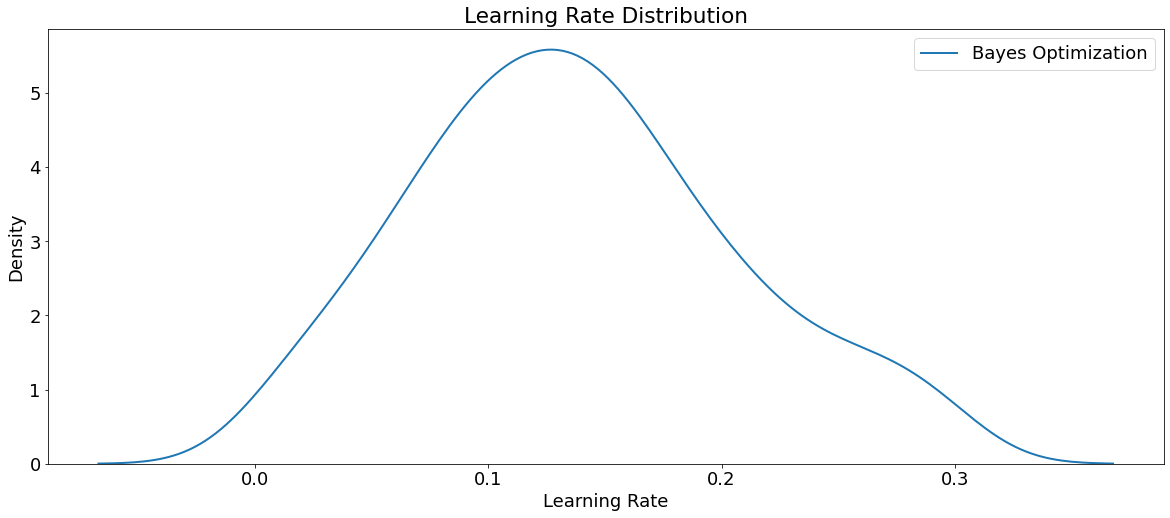

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

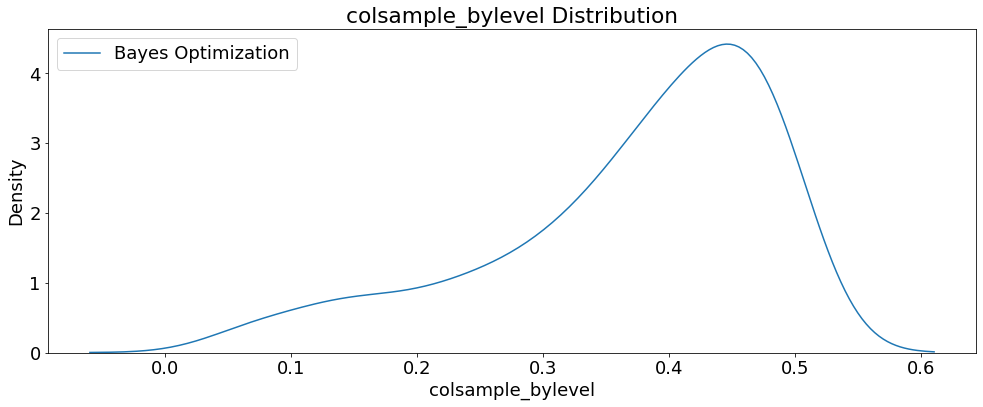

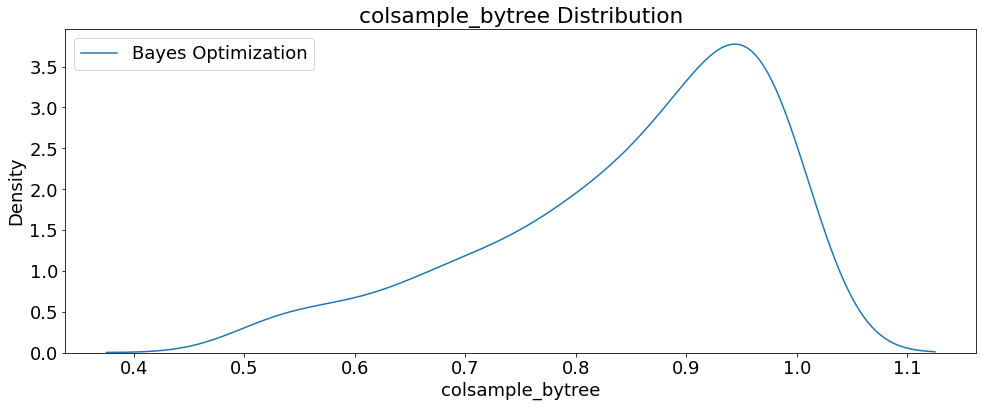

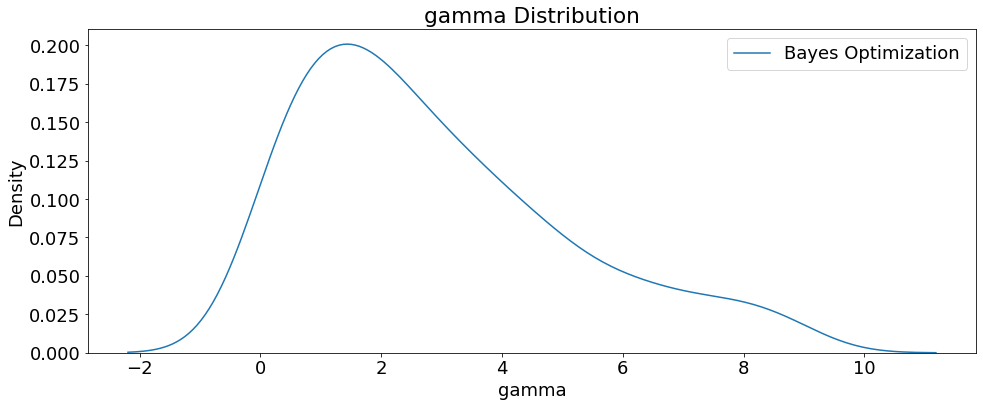

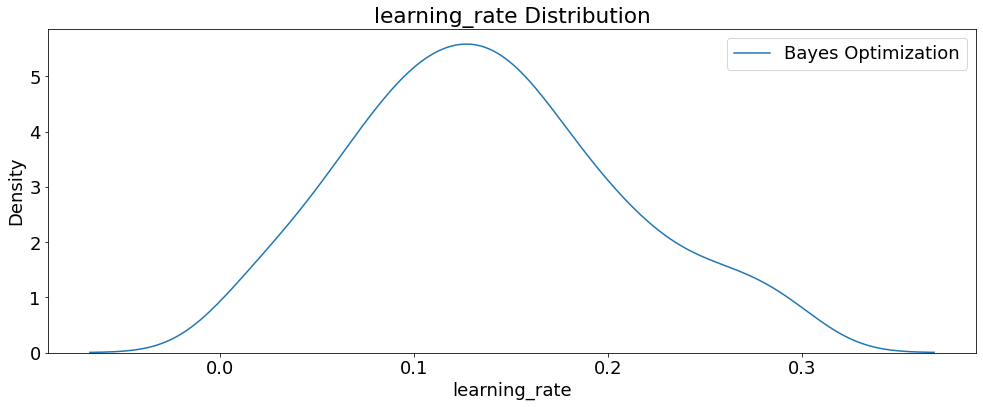

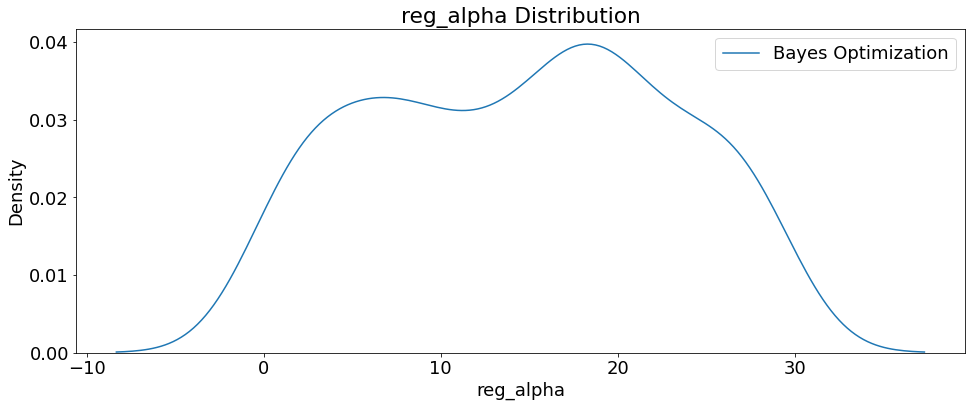

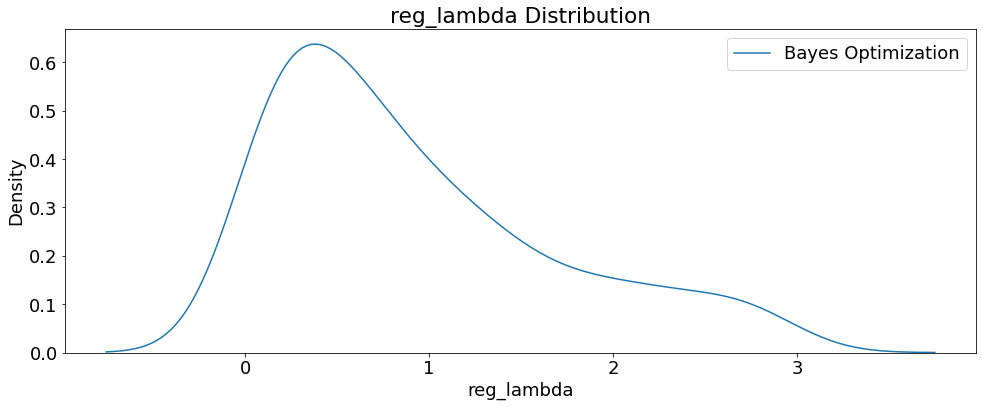

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                     'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label = 'Bayes Optimization')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


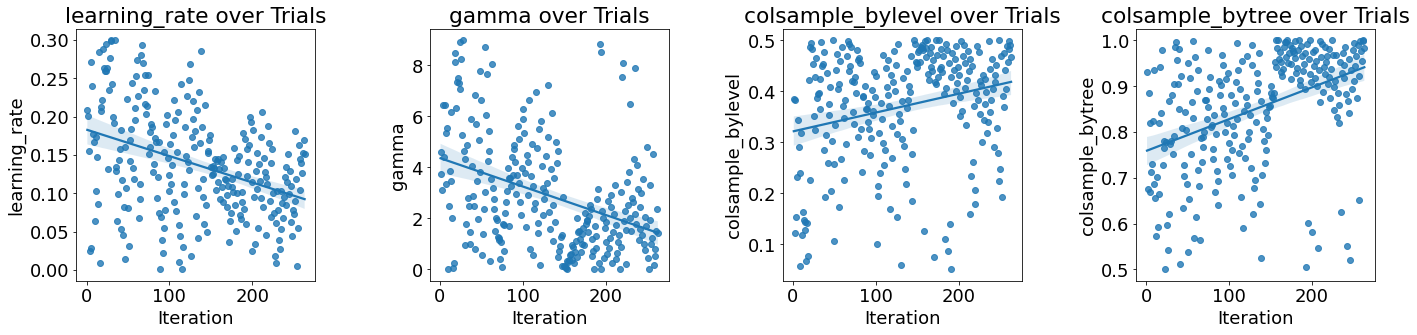

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


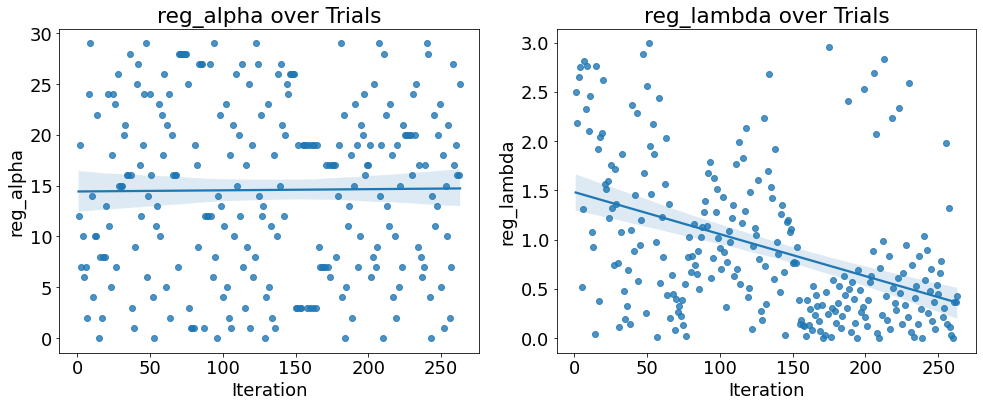

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize = (14, 6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
        sns.regplot('iteration', hpo, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

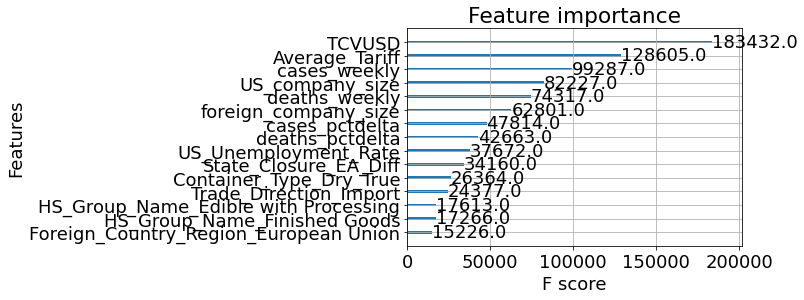

In [ ]:
# Plot the feature importance from best model result
my_dpi=96

plot_importance(best_bayes_model, max_num_features = 15)

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

In [ ]:
# Get the weights
X_test1 = pd.DataFrame(X_test, columns=X_test.columns)                                                                    

# Store feature weights in an object
html_obj = eli.show_weights(perm_importance,
                            feature_names = X_test1.columns.tolist())

html_obj 

Weight,Feature
0.9194 ± 0.0021,TCVUSD
0.2980 ± 0.0017,Average_Tariff
0.1625 ± 0.0014,HS_Group_Name_Finished Goods
0.1408 ± 0.0021,Trade_Direction_Import
0.1057 ± 0.0010,HS_Group_Name_Raw Input
0.0602 ± 0.0012,cases_weekly
0.0522 ± 0.0009,deaths_weekly
0.0486 ± 0.0007,State_Closure_EA_Diff
0.0484 ± 0.0004,HS_Group_Name_Pharma
0.0471 ± 0.0012,Container_Type_Dry_True


In [18]:
################################################################################
################### Test trained model on 2020 on 2018-19 ######################
################################################################################

In [19]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [20]:
# Read data
df = pd.read_csv('MaritimeTrade_10-19_MLP.csv', low_memory=False)
df = df.drop_duplicates()
print('Number of rows and columns:', df.shape)

Number of rows and columns: (23259149, 13)


In [21]:
# Create variables that did not exist preCOVID to match with COVID data
df = df.copy()
df.loc[:,'cases_weekly'] = 0
df.loc[:,'deaths_weekly'] = 0
df.loc[:,'State_Closure_EA_Diff'] = 0
df.loc[:,'cases_pctdelta'] = 0
df.loc[:,'deaths_pctdelta'] = 0

df['Container_Type_Dry'] = df['Container_Type_Dry'].astype('str')
df['Container_Type_Dry'] = df['Container_Type_Dry'].replace('0','False')
df['Container_Type_Dry'] = df['Container_Type_Dry'].replace('1','True')

In [22]:
# Rename to match variable format in 2018-19
df.rename(columns = {'us_company_size': 'US_company_size'}, inplace = True) 

In [23]:
# Drop year variable
df = df.drop(['Year'], axis=1)

In [24]:
# Sample due to memory constraints
df_sample = df.sample(n=10000000)

del df

In [25]:
# Prepare 2018-19 to fit model train on 2020
X_test1 = df_sample.drop(['Metric_Tons'],axis=1)
y_test1 = df_sample['Metric_Tons']

del df_sample

In [26]:
# Testing set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

In [27]:
# Test: Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

In [28]:
# MinMax Scaling
mn = MinMaxScaler()
X_test1 = pd.DataFrame(mn.fit_transform(X_test1), columns = X_test1.columns)

In [29]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Results/Xgboost/Results/

/content/drive/MyDrive/MaritimeTrade/Results/Xgboost/Results


In [30]:
# Re-create the best model and train on the training data
best_bayes_model_1019 = xgb.XGBRegressor(objective='reg:squarederror', 
                                    booster='gbtree',
                                    tree_method='gpu_hist', 
                                    scale_pos_weight=1,
                                    use_label_encoder=False,
                                    verbosity=0, 
                                    n_jobs=-1,
                                    random_state = seed_value, 
                                    **best_bayes_params)

# Fit the model
best_bayes_model_1019.fit(X_test1, y_test1)

# Save model
Pkl_Filename = 'Xgboost_HPO_train2020_testPreCovid_300_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model_1019, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Xgboost_HPO_train2020_testPreCovid_300_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
# Model Metrics
print('\nModel Metrics for Xgboost HPO Train 2020 Test PreCovid')
y_test_pred = best_bayes_model_1019.predict(X_test1)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test1, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test1, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test1, y_test_pred)))


Model Metrics for Xgboost HPO Train 2020 Test PreCovid
MSE train: 67.279, test: 77697.904
RMSE train: 8.202, test: 278.743
R^2 train: 0.892, test: 0.801


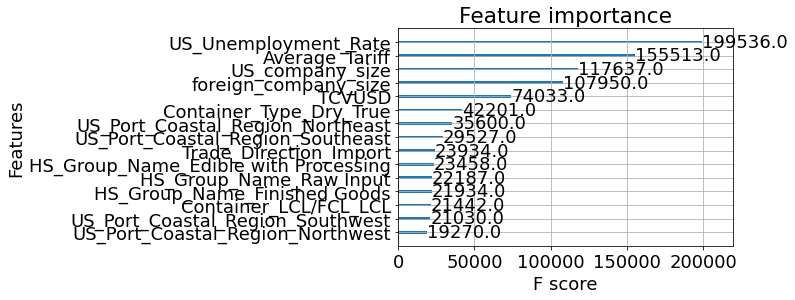

In [ ]:
# Plot the feature importance from best model result
my_dpi=96
plot_importance(best_bayes_model_1019, max_num_features = 15)
plt.savefig('MaritimeTrade_Xgboost_HPO_train20testPreCovid_300_GPU_FeatureImportance.png',
            dpi=my_dpi * 10, bbox_inches='tight')

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
check_additivity = False
explainer = shap.TreeExplainer(best_bayes_model_1019)
#
shap_values = explainer.shap_values(X_test1, check_additivity=check_additivity)

#shap_values = explainer.shap_values(X=data_x, y=data_y, check_additivity=check_additivity)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

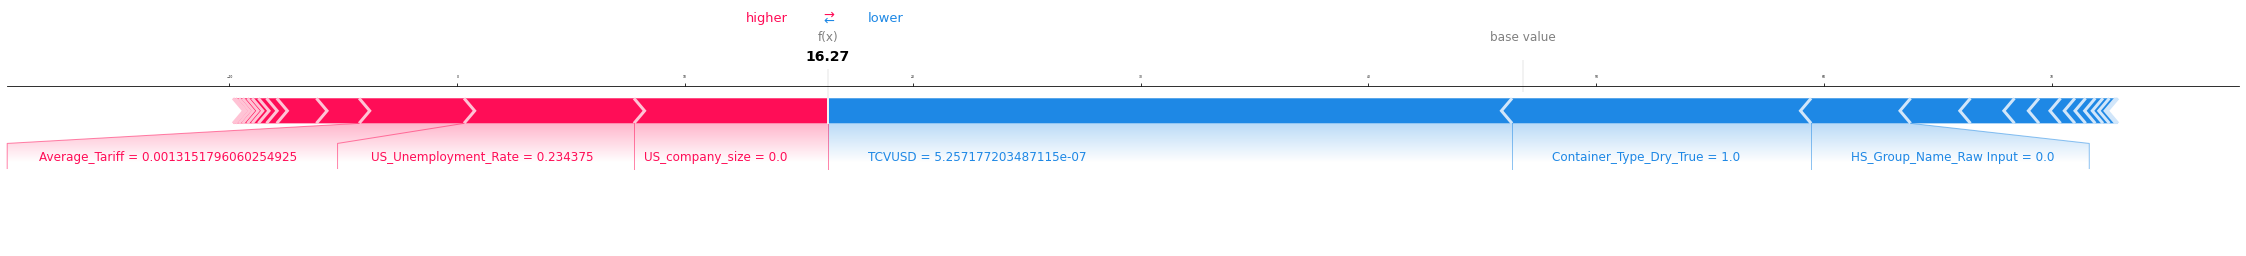

In [ ]:
# Visualize the first prediction's explanation
my_dpi=96
fig = plt.figure()
plt.rcParams.update({'font.size': 3})
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test1.iloc[0,:], 
                show=False, matplotlib=True, figsize=(40, 3)).savefig('Xgboost_HPO_300_GPU_train20testPreCovid_ShapForcePlot_TestSet.png', 
                                                     dpi=my_dpi, bbox_inches='tight')

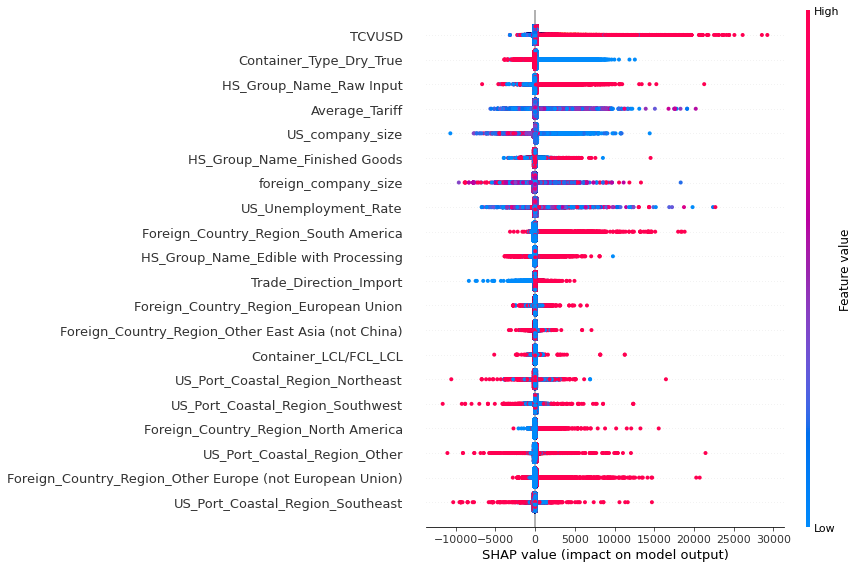

In [ ]:
# Test Set: Summarize the effects of all the features
my_dpi=96
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.summary_plot(shap_values, X_test1, show=False)
fig.savefig('Xgboost_HPO_300_GPU_train20testPreCovid_ShapSummary_TestSet.png', dpi=my_dpi, 
            bbox_inches='tight')

In [31]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model_1019,
                                        random_state=seed_value).fit(X_test1,
                                                                     y_test1)

In [32]:
# Store feature weights in an object
html_obj = eli.show_weights(perm_importance,
                            feature_names = X_train.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Results/Xgboost/Results/best_bayes_train20testPreCovid_HPO_300_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode("UTF-8"))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Results/Xgboost/Results/best_bayes_train20testPreCovid_HPO_300_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

Weight,Feature
1.3308 ± 0.0172,TCVUSD
0.7005 ± 0.0204,Average_Tariff
0.6091 ± 0.0209,US_Unemployment_Rate
0.4151 ± 0.0115,Foreign_Country_Region_Southeast Asia
0.3555 ± 0.0068,Container_Type_Dry_True
0.3477 ± 0.0126,US_company_size
0.3103 ± 0.0112,Foreign_Country_Region_Middle East & North Africa
0.3088 ± 0.0237,foreign_company_size
0.1812 ± 0.0048,Foreign_Country_Region_South America
0.1585 ± 0.0157,HS_Group_Name_Vices


In [33]:
# Explain weights
explanation = eli.explain_weights_sklearn(perm_importance,
                            feature_names = X_train.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('MaritimeTrade_best_bayes_train20testPreCovid_HPO_300_GPU_WeightsExplain.csv',
           index=False, encoding='utf-8-sig')